In [20]:
from cmdstanpy import CmdStanModel
import pandas as pd
import arviz as az 
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns

The goal of this excercise is to create a binomial model, use prior predictive distributions to select a proper prior and then using posterior predictive distributions.

We will be considering a following case:

Typical effects of administering certain vaccine result in an allergic reaction in 20% cases on average. This is what we know a priori

We are testing a new vaccine, for which we performed a trial on 50 patients registering 7 allergic reactions. We want to verify what is the allergic reaction probability for new trial and what is the probability that it is lower than for normal vacine. We assume that each patient treatment is exchangeable.

# Ex. 1. Modeling prior predictive distribution

1. Create a Stan model, which will consist of only ```generated quantites``` block.
2. In this block define integer variable ```N``` for number of trials equal to 50, integer variable ```y``` for number of successes and real ```p``` for probability of allergic reaction. Remember to use necessary constraints.
3. Assign a prior for  ```p``` (appropriate random number generator) that will represent our knowledge about typical cases. You can do it either analytically or by using simulations. 
4. Sample from binomial distribution, that will use ```N``` and sampled ```p``` to generate number of allergic reactions ```y```.
5. Generate 1000 samples (pair of ```p``` an ```y```) by calling appropriate method in ```cmdstanpy```. Remeber to set ```fixed_param=True```.
6. Compute ratio of allergic reactions for each sample and create a histogram.
7. Verify if mean of the ratio is consistent with prior knowledge, otherwise modify prior parameters. Describe your reasoning in the report. 


In [21]:
gen_quant = CmdStanModel(stan_file='code_1.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


In [22]:
samples = gen_quant.sample(data={"N":50},
                           fixed_param=True, 
                            iter_sampling=1000, 
                            iter_warmup=0, 
                            chains = 1)

INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


In [23]:
samples_df = samples.draws_pd()
samples_df

,lp__,accept_stat__,y,theta
0,0.0,0.0,12.0,0.185926
1,0.0,0.0,9.0,0.204568
2,0.0,0.0,14.0,0.204000
3,0.0,0.0,4.0,0.185507
4,0.0,0.0,10.0,0.200269
...,...,...,...,...
995,0.0,0.0,13.0,0.198584
996,0.0,0.0,10.0,0.179071
997,0.0,0.0,8.0,0.210235
998,0.0,0.0,11.0,0.200148


[]

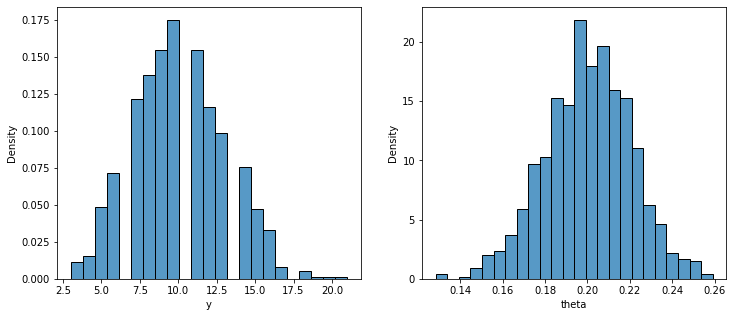

In [24]:
fig, axs = plt.subplots(1,2, figsize=(12,5))
sns.histplot(data=samples_df, x="y", stat="density", ax=axs[0])
sns.histplot(data=samples_df, x="theta", stat="density", ax=axs[1])
plt.plot()

In [25]:
samples_df["theta_verify"] = 1 - (50 - samples_df["y"])/50
samples_df

,lp__,accept_stat__,y,theta,theta_verify
0,0.0,0.0,12.0,0.185926,0.24
1,0.0,0.0,9.0,0.204568,0.18
2,0.0,0.0,14.0,0.204000,0.28
3,0.0,0.0,4.0,0.185507,0.08
4,0.0,0.0,10.0,0.200269,0.20
...,...,...,...,...,...
995,0.0,0.0,13.0,0.198584,0.26
996,0.0,0.0,10.0,0.179071,0.20
997,0.0,0.0,8.0,0.210235,0.16
998,0.0,0.0,11.0,0.200148,0.22


[]

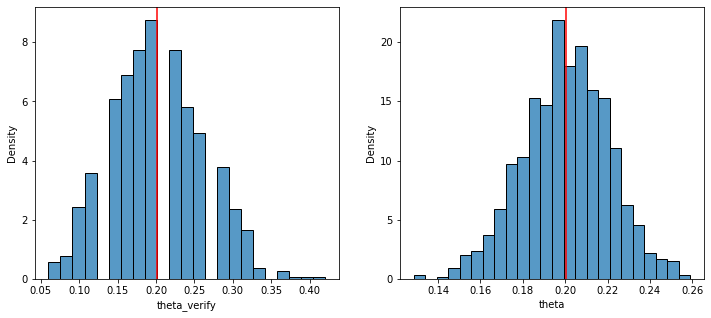

In [26]:
mean_theta = samples_df["theta"].mean()
mean_theta_verify = samples_df["theta_verify"].mean()

fig, axs = plt.subplots(1,2, figsize=(12,5))
sns.histplot(data=samples_df, x="theta_verify", stat="density", ax=axs[0])
axs[0].axvline(mean_theta_verify, ymin=0, ymax=12, color="r")

sns.histplot(data=samples_df, x="theta", stat="density", ax=axs[1])
axs[1].axvline(mean_theta, ymin=0, ymax=23, color="r")
plt.plot()

In [27]:
print(f"mean_theta = {mean_theta:.3f}, mean_theta_verify={mean_theta_verify:.3f}, diff={np.abs(mean_theta - mean_theta_verify):.3f}")

mean_theta = 0.200, mean_theta_verify=0.201, diff=0.001


The mean of the prior is close to the mean of the actual results - thus we can conclude that the prior we defined in the stan model works.

In order to better the understanding of stan I decided to try and use a different distribution - a reparametrised version of beta distribution. Here the probability density function is constructed by replacing the standard parameters of beta distribution with 𝛼=𝜙𝜇 and 𝛽=𝜙(1−𝜇)


In [28]:
gen_quant_beta = CmdStanModel(stan_file='code_1_beta.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


In [29]:
samples_beta = gen_quant_beta.sample(data={"N":50, 
                                 "fi":0.02, 
                                 "mu":0.2},
                           fixed_param=True, 
                            iter_sampling=1000, 
                            iter_warmup=0, 
                            chains = 1)

INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


[]

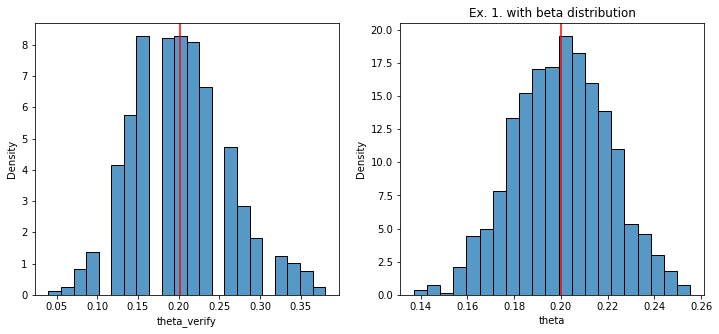

In [30]:
# necessary transformations and additional column
samples_df = samples_beta.draws_pd()
samples_df["theta_verify"] = 1 - (50 - samples_df["y"])/50

# drawing similar graphs as to code_1.stan
mean_theta = samples_df["theta"].mean()
mean_theta_verify = samples_df["theta_verify"].mean()

fig, axs = plt.subplots(1,2, figsize=(12,5))
sns.histplot(data=samples_df, x="theta_verify", stat="density", ax=axs[0])
axs[0].axvline(mean_theta_verify, ymin=0, ymax=12, color="r")

sns.histplot(data=samples_df, x="theta", stat="density", ax=axs[1])
axs[1].axvline(mean_theta, ymin=0, ymax=23, color="r")
plt.title("Ex. 1. with beta distribution")
plt.plot()

In [31]:
print(f"mean_theta = {mean_theta:.3f}, mean_theta_verify={mean_theta_verify:.3f}, diff={np.abs(mean_theta - mean_theta_verify):.3f}")

mean_theta = 0.200, mean_theta_verify=0.202, diff=0.002


The results are very similar to our previous approach, however here we are sure that the generated theta won't ever have values impossible for probability to achieve (e.g. lower than zero or bigger than one). Additionally, here mean of theta is exactly what we set the peak to be - more accurate results.

# Ex. 2. Modeling posterior and posterior predictive distribution

1. Create a Stan model in which:
   - ```N``` and ```y``` are appropriately defined in the ```data``` block. [DONE]
   - ```p``` is defined in the parameters block. [DONE]
   - binomial likelihood and prior (selected using prior predictive distribution) are defined in the model block. [DONE - *I think?*]
   - new integer variable ```y_pred``` in the generated quantities block. [DONE]
   - sample ```y_pred``` using values of parameter ```p``` and input variable ```N``` [DONE]
2. Generate default number of samples from appropriate method in ```cmdstanpy```.
3. Compute ratio of predicted allergic reactions for each sample and create a histogram.
4. Compute the expected value and 94% density interval of the predicted ratio, compare it with expected value and 94% density interval of parameter ```p```. Use ```arviz``` package.
5. Compute the probability that ratio is lower than the average probability from traditional vaccines (count the number of simulated ratios that are smaller).


In [59]:
gen_quant_2 = CmdStanModel(stan_file='code_2.stan')

INFO:cmdstanpy:compiling stan file /home/Lab3/code_2.stan to exe file /home/Lab3/code_2
INFO:cmdstanpy:compiled model executable: /home/Lab3/code_2


In [60]:
seed = 8022000 #integer, your date of birth in the DDMMYYYY format without leading zero (or if you are GPRD weary, use any other date you wish)
# result_1 = model_samp_st.sample(data=data,seed=seed)

samples_2 = gen_quant_2.sample(data={"N":50, "y":7,
                                     "fi":0.02, 
                                     "mu":0.2},
                            seed=seed)

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed

chain 3 |██████████| 00:00 Sampling completed
chain 4 |██████████| 00:00 Sampling completed                       

INFO:cmdstanpy:CmdStan done processing.


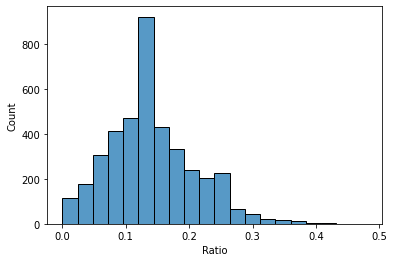

In [69]:
samples_df_2 = samples_2.draws_pd()
samples_df_2["Ratio"] = samples_2_df["y_pred"]/50

sns.histplot(data=samples_df_2, x="Ratio", bins=20)
plt.show()

# not exaclty appropriate with the mean we were expecting? or is the new data about 50 to 7 so important here?

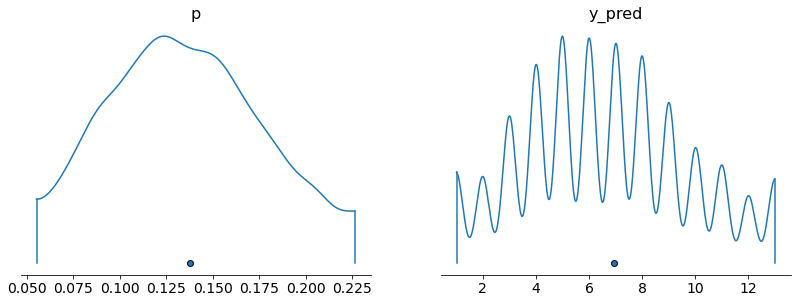

In [73]:
az.plot_density(samples_2)
plt.show()
# p density is similar to Ratio graph, but there is a strong peak in 
# ratio where there is the expected value calculated for p

In [78]:
total_number = samples_df_2.shape[0]
counted_lower_ratios = (samples_df_2["Ratio"] < 0.2).sum()

percentage_of_lower_ratios = counted_lower_ratios/total_number * 100

print(f"Percentage of lower ratios than the average for vaccines: {percentage_of_lower_ratios}%")


Percentage of lower ratios than the average for vaccines: 79.14999999999999%
